In [1]:
# Setup & Drive Mount

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install -q torch transformers datasets peft bitsandbytes accelerate trl tqdm matplotlib

import os, json, math, random
from dataclasses import dataclass
import torch

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

from peft import LoraConfig, get_peft_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 43.8 MB/s eta 0:00:00


In [3]:
# config

BASE_MODEL_ID   = "gpt2-medium"
OUT_DIR         = "./results/instruction_qlora"
SEED            = 42

MAX_LENGTH      = 256
LR              = 2e-4
EPOCHS          = 1
BATCH_SIZE      = 8
GRAD_ACCUM      = 2
LOG_STEPS       = 50
EVAL_STEPS      = 100
SAVE_STEPS      = 500

os.makedirs(OUT_DIR, exist_ok=True)
random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# Dataset: Dolly 15K
# Each row has: instruction, input, output

ds = load_dataset("databricks/databricks-dolly-15k", split="train")
ds = ds.shuffle(seed=SEED).select(range(12000))
ds = ds.train_test_split(test_size=0.02, seed=SEED)

INSTR_TPL = ( # string template
    "### Instruction:\n{instruction}\n\n"
    "### Input:\n{inp}\n\n"
    "### Response:\n{out}\n"
)

def format_example(ex):
    instr = ex.get("instruction", "").strip()
    inp   = ex.get("input", "").strip()
    out   = ex.get("output", "").strip()

    text = INSTR_TPL.format(instruction=instr, inp=inp, out=out)
    return {"text": text}

formatted_train = ds["train"].map(format_example, remove_columns=ds["train"].column_names)
formatted_eval  = ds["test"].map(format_example,  remove_columns=ds["test"].column_names)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [5]:
# Tokenizer

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Tokenization
def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length",
    )

train_data = formatted_train.map(preprocess, batched=True, remove_columns=["text"])
eval_data  = formatted_eval.map(preprocess,  batched=True, remove_columns=["text"])

# torch tensors
train_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
eval_data.set_format(type="torch",  columns=["input_ids", "attention_mask"])

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [6]:
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_cfg,
    device_map="auto",
)
model.config.pad_token_id = tokenizer.pad_token_id

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["c_attn", "c_proj", "c_fc"],  # GPT-2 blocks
)
model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 6,291,456 || all params: 361,114,624 || trainable%: 1.7422


In [7]:
# Data Collator

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

In [8]:
# Training Args

bf16_ok = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8

args = TrainingArguments(
    output_dir=OUT_DIR,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    logging_steps=LOG_STEPS,
    eval_steps=EVAL_STEPS,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM,
    num_train_epochs=EPOCHS,
    save_total_limit=2,
    report_to="none",
    bf16=bf16_ok,
    fp16=not bf16_ok,  # use fp16 if bf16 unavailable
)

In [11]:
# Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    data_collator=data_collator,
)

In [12]:
# Train and Evaluate

trainer.train()
trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)

metrics = trainer.evaluate()
print("Eval metrics:", metrics)

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


Eval metrics: {'eval_loss': 3.1949996948242188, 'eval_runtime': 0.0976, 'eval_samples_per_second': 20.5, 'eval_steps_per_second': 10.25, 'epoch': 1.0}


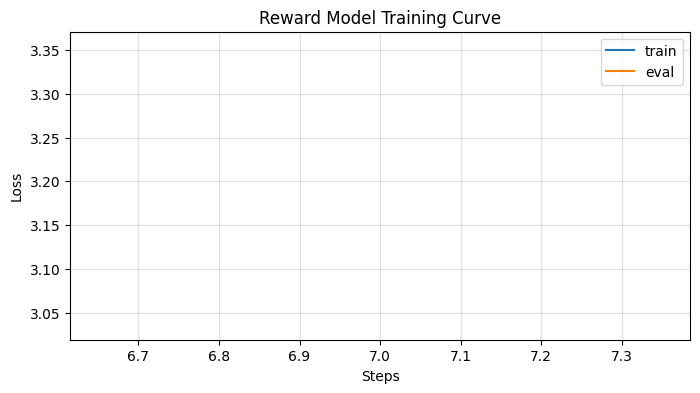

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

steps = [x["step"] for x in logs if "step" in x]
losses = [x["loss"] for x in logs if "loss" in x]
eval_steps = [x["step"] for x in logs if "step" in x]
eval_losses = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.figure(figsize=(8,4))
plt.plot(steps, losses, label="train")
plt.plot(eval_steps, eval_losses, label="eval")
plt.xlabel("Steps"); plt.ylabel("Loss")
plt.title("Reward Model Training Curve")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()